In [39]:
import os
from pprint import pprint as pp
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import copy
import seaborn as sns

%matplotlib inline
os.getcwd()

'/home/ryan/Documents/insight_projects/steam_prices/data_analysis'

In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import KFold


<H3>IMPORT STEAMDB FEATURES AND CLEAN MORE

In [41]:
df = pd.read_pickle('df_steamdb_timeseries.pkl')
since_sale_len = len(df.since_sale_lists[1])
print since_sale_len

21


In [42]:
#df.head()
current_epoch =  20 #the epoch in the bool list to predict
drop_columns = ['fprice','iprice','price_date','sale_bool',
                'formatted_no_holiday','saledates_no_holiday',
               'sale_bool_all','min_iprice','mip_slopes','dirty_isi']
df_feat_space = df.drop(drop_columns,axis=1)
df_feat_space = df_feat_space[df_feat_space.formatted.map(type) != type([])]
#df_feat_space = df_feat_space.drop(['formatted'])
#df_feat_space['specific_epoch_time_since'] = df_feat_space.since_sale_lists[3]
#df.head()

In [43]:
'''empty list replace'''
replacement_empty_list = list(df.iloc[1].sale_bool_no_holiday[0] - df.iloc[1].sale_bool_no_holiday[0][0] + (60*60*24*100.0))
#if there are no values, for now just use this empty list that assumes the last sale was more than one hundred days ago
#however, this may be problematic if there's a negative correlation for games with sales and the time since the last game
#to_series = df_feat_space.since_sale_lists

to_series = df_feat_space.since_sale_lists
check = [x for x in to_series]
check_copy = copy.deepcopy(check)

just_one_epoch = list()
for i,v in enumerate(check):
    if v == []:
        check_copy[i] = replacement_empty_list
    cur_epoch_time_since = check_copy[i][current_epoch]
    just_one_epoch.append(cur_epoch_time_since)

df_feat_space['specific_epoch_time_since'] = just_one_epoch
#rint(check)
#[df_feat_space.head().iloc['since_sale_lists']

In [44]:
'''change boolean into 1 or 0'''
df_feat_space.has_price_slope = df_feat_space.has_price_slope.apply(lambda x:x*1)

<h3>STEAM SCRAPED FEATURES

In [46]:
df_steamscraped = pd.read_pickle('steam_features.pkl')

In [47]:
df_steamscraped.head()
drop_ss_cols = ['developer','game_name','meta_score','new_id','publisher','release_date','tag_data']
df_ss_features = df_steamscraped.drop(drop_ss_cols,axis =1)
df_ss_features.head()

,appid,time_stamp_rd,big_publisher,publisher_category,meta_score_mean_interpolate
0,317950,1416297600,False,small_publisher,72.40834
1,315940,1416297600,False,small_publisher,72.40834
2,363510,1416297600,False,small_publisher,72.40834
3,348870,1416297600,False,small_publisher,72.40834
4,348700,1416297600,False,small_publisher,72.40834


In [48]:
df_ss_features.big_publisher = df_ss_features.big_publisher.apply(lambda x:x*1) #turn into 1 or 0

In [49]:
unique_pubs = df_ss_features.publisher_category.unique()
le = LabelEncoder()
le.fit(df_ss_features.publisher_category)
df_ss_features['pub_cat_int'] = le.transform(df_ss_features.publisher_category)

In [50]:
df_merged_features = pd.merge(left=df_ss_features,right=df_feat_space, left_on='appid', right_on='appid')

In [61]:
df_merged_features.head()

,time_stamp_rd,big_publisher,meta_score_mean_interpolate,pub_cat_int,sale_count,has_price_slope,dirty_isi_mean,specific_epoch_time_since
0,1416297600,0,72.40834,56,2,0,95.333333,1481476
1,1416297600,0,72.40834,56,2,0,96.000000,12367951
2,1416297600,0,72.40834,56,1,0,144.000000,1466852
3,1416297600,0,72.40834,56,3,0,71.750000,2899953
4,1416297600,0,69.00000,56,2,0,95.666667,2086318


In [ ]:
'''make y values after tables are merged and everything else is calculated'''

In [51]:
'''make y values'''
y = list()
for i,v in enumerate(df_merged_features.sale_bool_no_holiday):
    if v == []:
        y_in = 0
    else:
        y_in = v[1][current_epoch] #1 is the index of the boolean list
    y.append(y_in)

y = np.array(y)

In [52]:
drop_more_columns = ['appid','formatted','since_sale_lists', 'sale_bool_no_holiday','publisher_category']
df_merged_features = df_merged_features.drop(drop_more_columns,axis=1)


In [54]:
X = df_merged_features.as_matrix().astype(np.float)

In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print "Feature space holds %d observations and %d features" % X.shape

Feature space holds 4163 observations and 8 features


In [56]:

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


In [57]:
def accuracy(y_true,y_pred):
    # NumPy interprets True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Support vector machines:
0.901
Random forest:
0.968
K-nearest-neighbors:
0.945


In [ ]:
chance_accuracy = (1 - sum(y)*1.0 / y.size)

In [ ]:
from sklearn.metrics import confusion_matrix

y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
]


In [ ]:
confusion_matrices[0]

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


look_at_model = 1
plot_confusion_matrix(confusion_matrices[look_at_model][1],confusion_matrices[look_at_model][0])


In [58]:
def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob, y_test

In [59]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob,y_test = run_prob_cv(X, y, RF, n_estimators=10)
pred_sale = pred_prob[:,1]
is_sale = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_sale)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_sale[pred_sale == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.000000,3424,0.009054
1,1.000000,204,0.990196
2,0.100000,187,0.101604
3,0.200000,77,0.155844
4,0.300000,54,0.370370
5,0.900000,52,0.826923
6,0.800000,45,0.777778
7,0.400000,36,0.277778
8,0.700000,27,0.666667
9,0.500000,26,0.307692


In [ ]:
pred_sale.

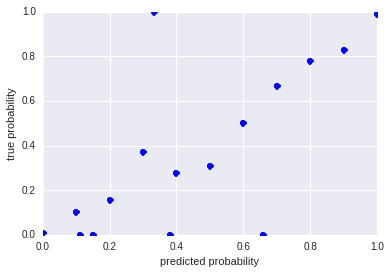

In [60]:
'''plot predicted probability by true probability'''
counts = counts.sort('pred_prob')
plt.plot(counts.pred_prob,counts.true_prob, 'bo')
plt.xlabel('predicted probability')
plt.ylabel('true probability')